# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [3]:
import os
import pickle
import datetime
import numpy as np
import random as rand
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
# TODO: fill this in based on where you saved the training and testing data
training_file = "lab 2 data/train.p"
testing_file = "lab 2 data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[1].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

### Seeing the Data
Let's see what sorts of images we'll be training a classifier on!

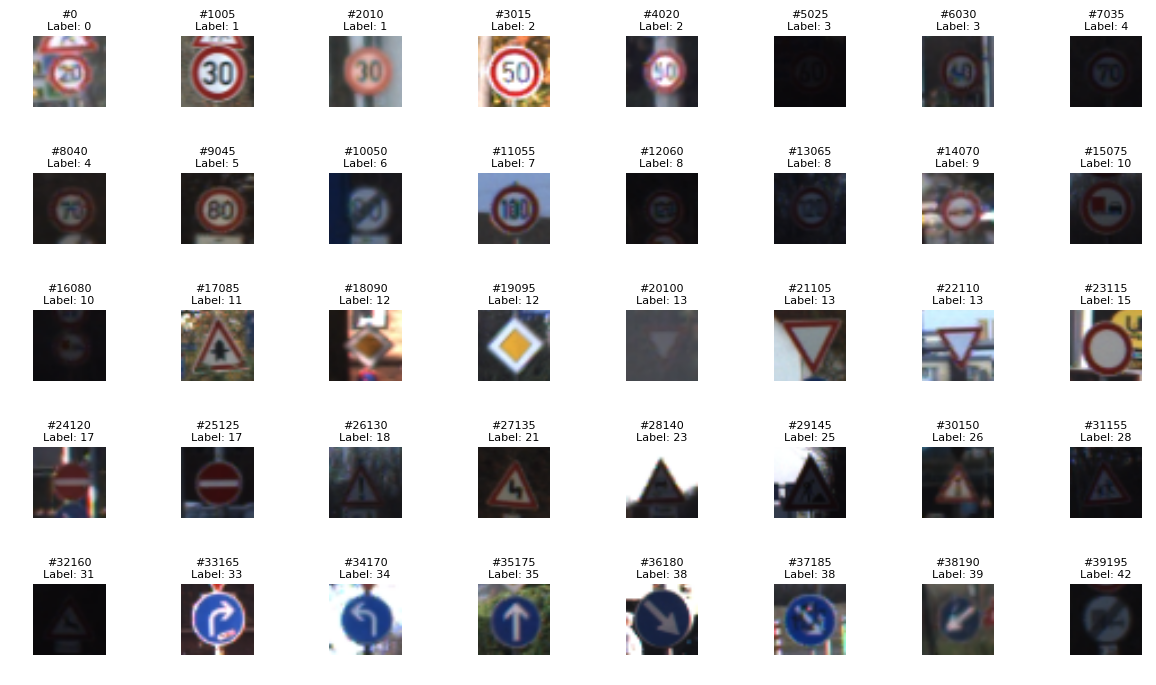

In [7]:
fig = plt.figure(figsize=(12, 7))
for i, n in enumerate(range(0,39209,1005)):
    fig.add_subplot(5, 8, i+1)
    img = Image.fromarray(X_train[n], 'RGB')
    plt.axis("off")
    plt.title("#" + str(n) + "\nLabel: " + str(y_train[n]), fontsize=8)
    plt.imshow(img)
plt.tight_layout()
plt.show()

Pretty cool!  
I wonder how these labels are distributed

### Label Distribution

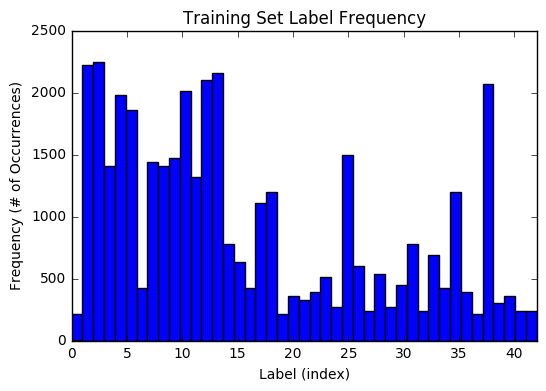

In [8]:
n, bins, patches = plt.hist(y_train, bins=43)
plt.axis([0,42,0,2500])
plt.title("Training Set Label Frequency")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("Label (index)")

Some of the signs in the dataset appear way more frequently than do some of the other signs.

In [9]:
np.argmax(n), np.argmin(n)

(2, 0)

From the above, we can see that the **most** common label is `2`.  
Additionally, the **least** common label is `0`.

In [10]:
max(n) / min(n)

10.714285714285714

More specifically, there are almost 11 times **more** instances of label `2` than there are of label `0`.

Thus, this dataset is super [unbalanced](https://carnd-udacity.atlassian.net/wiki/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image).

### The "Average" Image
I wonder if there's anything we can notice about the average image

In [33]:
avg_img = np.average(X_train, axis=0)

In [67]:
avg_img = np.array(np.round(avg_img), dtype=np.uint8)

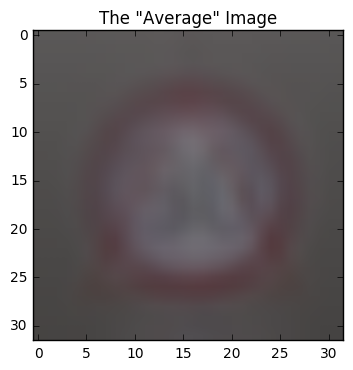

In [68]:
fig1 = plt.figure()
img = Image.fromarray(avg_img, 'RGB')
img.show()
plt.title("The \"Average\" Image")
plt.imshow(img)

Well that's nifty!  I'm not sure how useful it is, but it does convey a sense of the centrality of the signs in the image, and that, in general, these images present some kind of white sign, bordered by red, with digits in the middle.
Let's split this average image into its constituent channels to see if there's anything we can notice there.

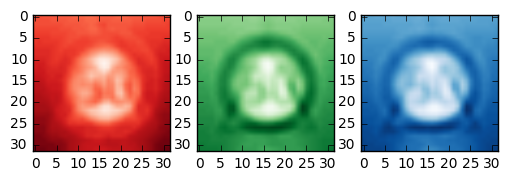

In [89]:
red, green, blue = img.split()
colors = ("Reds_r", "Greens_r", "Blues_r")
split = (red, green, blue)
fig = plt.figure()
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(split[i])
    plt.set_cmap(colors[i])

(Note, the channels in the above images have been normalized, as is the default behavior for [`plt.imshow()`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow))

As shown above, in the **Red** channel, it would appear that, on average, our signs read **90**, while they appear to read **50** in the other channels.

Additionally, in the **Blue** channel and especially in the **Green** channel, the bordering of the intense ("white") foreground is especially prominent.

I would suspect that a Neural Net could make use of the information contained in each of these channels in different ways:  
For instance, to detect the boundaries of the signs, it would appear that the Neural Net could rely heavily on the **Green** and **Blue** channels.  
Or, to be able to read the test on the sign, it may be advantageous for the Neural Net to focus on the information contained in the **Red** channel.  
The Neural Net may even be able to build a consensus of what it thinks it's detecting by querying multiple channels, for example about whether it's seeing a **90** or a **50**.

### Sign Location Heatmap
All of the images we're working with in the pickled data have been resized to `(32, 32)` and more or less centered, but `train["coords"]` retains the location of the signs in the original image.

For funsies, let's see where the corners generally are.

In [14]:
allPoints = []
for i, box in enumerate(train['coords']):
    allPoints.append((box[0] / train['sizes'][i][0], box[1] / train['sizes'][i][1]))
    allPoints.append((box[0] / train['sizes'][i][0], box[3] / train['sizes'][i][1]))
    allPoints.append((box[2] / train['sizes'][i][0], box[1] / train['sizes'][i][1]))
    allPoints.append((box[2] / train['sizes'][i][0], box[3] / train['sizes'][i][1]))

In [15]:
xs,ys = zip(*allPoints)

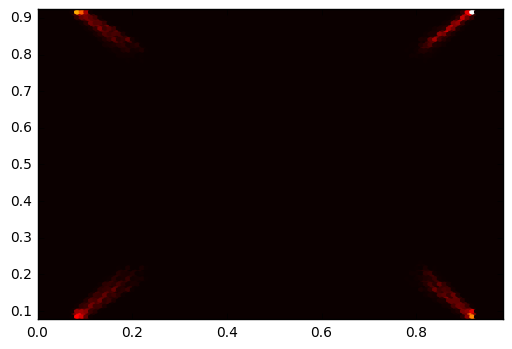

In [16]:
plt.hexbin(xs,ys,cmap="hot")
plt.show()

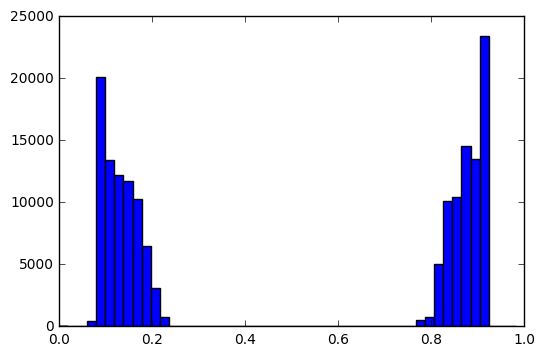

In [17]:
plt.hist(xs, bins=50)
plt.show()

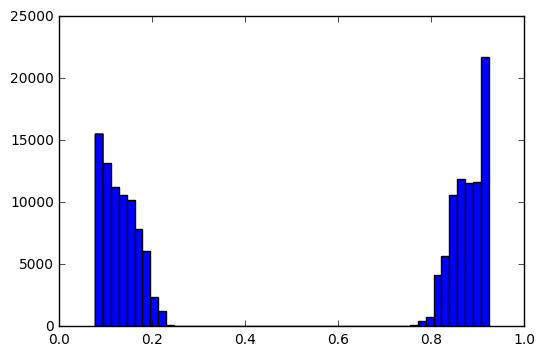

In [18]:
plt.hist(ys, bins=50)
plt.show()

<img style="float: left; margin-left: 60px" src="https://memecrunch.com/meme/29ZEI/i-don-t-know-what-i-expected/image.jpg?w=462&c=1">

Onward!

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### RGB to Grayscale

In [4]:
def toGrayscale(img_array):
    '''
    img_array: a numpy array representing a 3-channel image
    returns a grayscale Image
    '''
    img = Image.fromarray(img_array, 'RGB')
    gray = img.convert('L')
    return gray

15268


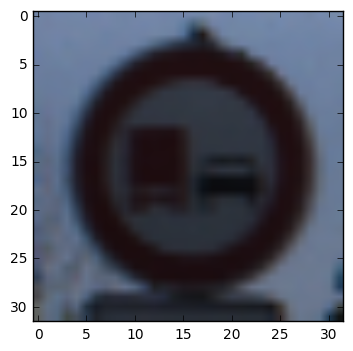

In [73]:
#choice = rand.randint(0,39209)
choice = 15268
print(choice)
ex = X_train[choice]
plt.imshow(ex)

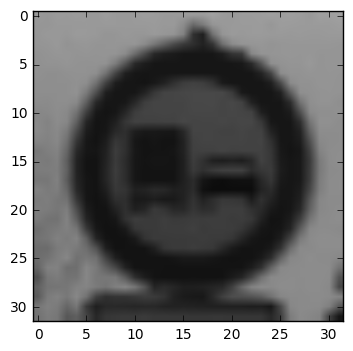

In [81]:
gray = toGrayscale(ex)
plt.imshow(gray, cmap="Greys_r", vmin=0, vmax=255)

#### Normalization

In [6]:
def normalize(gray_img_array):
    '''
    gray_img_array: a numpy array representing a 1-channel grayscale image
    returns a numpy array which has been linearly normalized
    
    https://en.wikipedia.org/wiki/Normalization_(image_processing)
    '''
    iMax = np.max(gray_img_array)
    iMin = np.min(gray_img_array)
    
    newMax = 255
    newMin = 0
    
    norm = lambda elem: (elem - iMin) * (newMax - newMin) / (iMax - iMin) + newMin
    elem_norm = np.vectorize(norm)
    
    return elem_norm(gray_img_array)

def imstat(img):
    print("Max value is: " + str(np.max(np.array(img))))
    print("Min value is: " + str(np.min(np.array(img))))

In [ ]:
normalized = normalize(np.array(gray))

Intensities for gray:
Max value is: 137
Min value is: 11

Intensities for normalized:
Max value is: 255.0
Min value is: 0.0


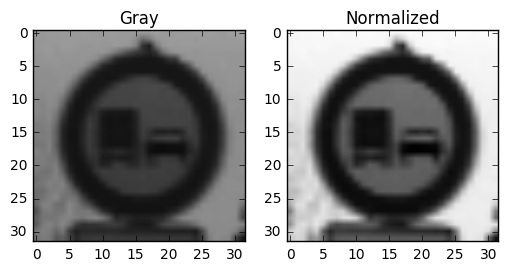

In [85]:
fig = plt.figure()
fig.add_subplot(1, 2, 1)
#gray.show()
plt.title("Gray")
plt.imshow(gray, norm=None, cmap="Greys_r", vmin=0, vmax=255)

fig.add_subplot(1, 2, 2)
#Image.fromarray(normalized).show()
plt.title("Normalized")
plt.imshow(normalized, norm=None, cmap="Greys_r", vmin=0, vmax=255)

print("Intensities for gray:")
imstat(gray)
print("\nIntensities for normalized:")
imstat(normalized)

In [7]:
def preprocess(img_array):
    return normalize(np.array(toGrayscale(img_array)))

### Question 1 

_Describe the techniques used to preprocess the data._

**Preliminary Thoughts**

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [ ]:
### (1) Dataset is unbalanced; generate additional data from under-populated classes to compensate (even with TF?)
### (2) changing to grayscale and normalizing is mentioned as a way of preprocessing
### (3) 99.8% achieved by inception models
### (4) we discussed building a TF model, and also that's what you're looking to do with ML, so maybe do that
### (5) Pre-training with an auto-encoder is mentioned, but not explained, and seems complicated

**Answer:**

To preprocess the data, images will be converted into grayscale, and then normalized to make full use of the intensity spectrum (0-255).

The helper functions to accomplish these preprocessing tasks are defined and demonstrated above.

This is largely because [Sermanet and LeCun](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) report better performance after having converted their images from full 3-channel color into grayscale, and then normalizing.

In [38]:
def reshapeAndPreprocess(x):
    '''
    Given a numpy array of inputs, first preprocess the inputs
    (convert to grayscale and normalize), then reshape the inputs.
    Returns a numpy array of preprocessed, reshaped inputs.
    '''
    X_proc = np.zeros((x.shape[0], x.shape[1], x.shape[2]))
    for i, a in enumerate(x):
        X_proc[i] = preprocess(a)
    return np.reshape(X_proc, (-1, 32, 32, 1))

Reshape and Preprocess the data.  This only needs to be done **once**, after which you can just load the pickle files.

In [ ]:
X_res = reshapeAndPreprocess(X_train)
X_test_res = reshapeAndPreprocess(X_test)

Save the reshaped, preprocessed data to a pickle file for future use.

In [93]:
pickle_file = 'pickles/X_res.pickle'
try:
  pickleData = open(pickle_file, 'wb')
  pickle.dump(X_res, pickleData, pickle.HIGHEST_PROTOCOL)
  pickleData.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [95]:
pickle_file = 'pickles/X_test_res.pickle'
try:
  pickleData = open(pickle_file, 'wb')
  pickle.dump(X_test_res, pickleData, pickle.HIGHEST_PROTOCOL)
  pickleData.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

On subsequent runs of this notebook, just load the pickle files to avoid re-doing costly processing

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Preliminary Thoughts**

In [25]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### (1) will need some convolutions, maybe follow the TF advanced tutorial?
### https://www.tensorflow.org/versions/r0.11/tutorials/deep_cnn/index.html
### Actually, the above is not very detailed, except for the raw source code

**Answer:**

Note, from above, that the training and testing data has already been split
```
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
```
The possibility exists to generate additional data in order to [balance under-populated classes](https://medium.com/@vivek.yadav/dealing-with-unbalanced-data-generating-additional-data-by-jittering-the-original-image-7497fe2119c3#.x727w2lda), and indeed the rationale for eliminating a model's bias towards common data is cogent.  
However, such preprocessing techniques are contrary to the spirit of Machine Learning, whereby we would like to be able to feed data into as black of a box as possible and retrieve meaningful results.  Certainly this wish for a free lunch has its limitations, but it's not the case that every lunch needs to cost $20 USD.  
Not unrelatedly, the process itself of generating additional data can introduce insidious bias into the dataset if not done skillfully (which would be the case were I to try to generate additional data through jitter, since that is a process with which I am largely unfamiliar).  

While [methods](https://carnd-udacity.atlassian.net/wiki/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image) exist for generating additional jittered data, in the interest of not merely stitching together other people's work to create my pipeline, I will forego the step of generating additional data to balance an admittedly-unbalanced dataset.

In [25]:
def oneHot(y):
    y_hot = np.zeros((y.shape[0], 43))
    for i, e in enumerate(y):
        y_hot[i][e] = True
    return y_hot

In [26]:
y_hot = oneHot(y_train)
y_test_hot = oneHot(y_test)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

Note that we'll want to define a tensor for solving this problem, as that library provides a great deal of standardization and deep learning primitives.

TensorFlow is an interesting paradigm shift in programming, because rather than evaluating the expressions you write, TensorFlow constructs a computational graph from them, and will only begin evaluating them once you create a session and run it.

Construction of a TensorFlow model can thus be easily split into two conceptual categories:  
1. Building the Model, and
2. Running the Model

### 1. Building the Model
First off, let's add our input and output to the computational graph.

In [9]:
# Define the TensorFlow placeholder for each individual GTSRB image
tf_x = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name="x")

In [10]:
# Define the TensorFlow placeholder for the different number of classes in GTSRB (43)
tf_y = tf.placeholder(tf.float32, shape=[None, n_classes], name="y")

#### Defining a Model Architecture
Now, let's think about what our architecture should look like.  
Initially, to adhere as closely as possible to the principles discussed in lecture, the architecture chosen here mirrored that described in [Deep Neural Network in TensorFlow](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) above.

More specifically (depicted below):  
* The width of our hidden layer is `256`
* The hidden layer is a matrix multiply followed by a [ReLU](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#relu), thus achieving a two-layer network
* Dropout is employed during training with a `keep_prob` of `0.5`.  During testing, `keep_prob` is returned to `1.0`, effectively turning dropout off.
* The output layer is a simple linearly-activated layer
![Final Architecture](https://d17h27t6h515a5.cloudfront.net/topher/2016/October/580fe8f8_multi-layer/multi-layer.png)

The performance of this network, however, was terrible (see the [History of Performance](#History-of-Performance) section)

#### Defining a Better Model Architecture
With the wonderful benefit of hindsight, it appears that a convolutional neural net is the most promising architecture.  For a discussion of models which were discarded before I arrived at this one, see the [History of Performance](#History-of-Performance) section.

Convolutional neural nets [have been shown](http://ip.cadence.com/uploads/901/TIP_WP_cnn_FINAL-pdf) to have excellent performance on image recognition tasks (frequently outperforming humans, and certainly outperforming *this* human).

First off, let's define some **helper functions** that we'll use later to actually construct our neural net:

In [12]:
def initRandomNormal(shape, name):
    '''
    This is most useful for returning Weights and Biases tensors, since both are
    tf.Variables, and we generally want to initialize both to random values.
    
    Note that this helper function also requires that a name be passed.
    This is so that the relationship between Tensors is more obvious when
    viewed from TensorBoard.
    '''
    return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)

We've decided above that we're going to build and train a convolutional neural network (CNN), but what are the components of that network?

The CNN which will be used in this Jupyter Notebook was inspired by David Freiberger's comment in the [p-traffic-signs](https://carnd.slack.com/messages/p-traffic-signs/) channel of the SDCND Slack:
> conv [48,5,5] -> relu -> pool [2,2] -> conv [36,5,5] -> relu -> pool[2,2] -> flatten -> dense [128] -> relu -> dropout [0.5] -> softmax cross entropy classify

As such, it's going to need:  
1. Convolutional Layer(s),
2. Flattening Layer(s), and
3. Fully-Connected Layer(s)

The helper functions to define these layers are most eloquently stated in Hvass Labs' Convolutional Neural Network [Jupyter Notebook](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb).

In [my fork](https://github.com/mgruben/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb) of this notebook, I've added `name_scope` functionality and `SummaryWriter`s to allow the use of TensorBoard.

In [14]:
# https://github.com/mgruben/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   name,               # The name to give the summaries
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = initRandomNormal(shape=shape, name=name+"_W")
    tf.histogram_summary(name+"_weights", weights)
    # Create new biases, one for each filter.
    biases = initRandomNormal(shape=[num_filters], name=name+"_B")
    tf.histogram_summary(name+"_biases", biases)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [15]:
# https://github.com/mgruben/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [16]:
# https://github.com/mgruben/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 name,           # The name to give the summaries
                 use_relu=False): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = initRandomNormal(shape=[num_inputs, num_outputs], name=name+"_W")
    biases = initRandomNormal(shape=[num_outputs], name=name+"_B")
    tf.histogram_summary(name+"_weights", weights)
    tf.histogram_summary(name+"_biases", biases)
    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

As mentioned above, our guiding architectural beacon is David Freiberger's comment in the [p-traffic-signs](https://carnd.slack.com/messages/p-traffic-signs/) channel of the SDCND Slack:
> conv [48,5,5] -> relu -> pool [2,2] -> conv [36,5,5] -> relu -> pool[2,2] -> flatten -> dense [128] -> relu -> dropout [0.5] -> softmax cross entropy classify

Let's first unpack this a little bit, and discuss what this comment means, before building the layers into our TensorFlow computational graph below.

**First**:  
`conv [48,5,5] -> relu -> pool [2,2]`  
In my mind, this would mean that we're looking to implement a convolutional layer that takes the input, performs a 5x5 convolution on it, and generates 48 separate output images.  After this is done, we then would want to apply a ReLu to the layer, and then to perform 2x2 MaxPooling.

Now, as [Hvass Labs notes](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb):
 > relu(max_pool(x)) == max_pool(relu(x))

Therefore, if we perform our MaxPooling before our ReLU, we don't have to process nearly as much data with the ReLu.  That tweak will be useful in shaving training time for us here.

This layer appears in TensorBoard as below:
![Conv1 in TensorBoard](images/conv1_3.png)

**Second**:  
`conv [36,5,5] -> relu -> pool[2,2]`  
The discussion here largely mirrors the discussion above, except that we'll be taking in the 48 convoluted images (rather than the input), and we'll be outputting 36 convoluted images.  *Why* this works, I can't explain.  *That* this works, I can't dispute.

This layer appears in TensorBoard as below:
![Conv2 in TensorBoard](images/conv2_3.png)

**Third**:  
`flatten -> dense [128] -> relu -> dropout [0.5]`  
Here, we're providing a converter from the convolutional layer to the output layer.

Hvass says it best:
>A convolutional layer produces an output tensor with 4 dimensions. [If we want to use the output from the convolutional layer as input to the fully-connected layer,] we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.

In the process, we're again applying a ReLU, and here we're also for the first time implementing dropout.  Dropout can best be thought of as the neural net cutting off some (here, half) of the incoming data randomly.  The theory is that, since it doesn't always have access to all of its net, it must build a resiliant net with multiple redundancies.

This layer appears in TensorBoard as below:
![Flatten in TensorBoard](images/flatten_3.png)

**Fourth**, and finally:  
`softmax cross entropy classify`  
In this step, we perform basically the same functions as are suggested in the [Deep Neural Network in TensorFlow](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) lesson.  Since there are 43 types of signs, we want an output Tensor whose dimension is 43.  We perform softmax on that tensor so that the outputs we get can best be thought of as probabilities that the given input belongs to the i<sup>th</sup> class.  We use cross-entropy for [statistical](https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/) reasons.

This layer appears in TensorBoard as below:
![Output in TensorBoard](images/output_3.png)

Below, we actually create the layers described above.  Keep in mind that, with TensorFlow, this means only that they're added to our running computational graph.  Nothing is evaluated just yet.

Here's what it looks like at a high level:
![Model Architecture](images/graph3.png)

In [17]:
with tf.name_scope("Conv1"):
    filter_size_1 = 5
    num_filters_1 = 48
    # num_input_channels = 1, since greyscale image
    # filter_size = 5 denotes a 5x5 convolution filter
    # num_filters = 48 indicates that we will generate 48-channel output (one channel for each convoluted image)
    # use_pooling = True indicates that we will use 2x2 max-pooling
    layConv1, weightsConv1 = new_conv_layer(input=tf_x,
                                            num_input_channels=1,
                                            filter_size=filter_size_1,
                                            num_filters=num_filters_1,
                                            name="Conv1",
                                            use_pooling=True)

In [18]:
with tf.name_scope("Conv2"):
    filter_size_2 = filter_size_1
    num_filters_2 = 36
    # num_input_channels = 48, since 48 convolutions are input
    # filter_size = 5 denotes a 5x5 convolution filter
    # num_filters = 36 indicates that we will generate 36-channel output (one channel for each convoluted image)
    # use_pooling = True indicates that we will use 2x2 max-pooling
    layConv2, weightsConv2 = new_conv_layer(input=layConv1,
                                            num_input_channels=num_filters_1,
                                            filter_size=filter_size_2,
                                            num_filters=num_filters_2,
                                            name="Conv2",
                                            use_pooling=True)

In [20]:
keep_prob = tf.placeholder(tf.float32, name="keep_prob")
with tf.name_scope("Flatten"):
    layFlat, numFeatures = flatten_layer(layConv2)
    layFlat = tf.nn.relu(layFlat)
    layFlat = tf.nn.dropout(layFlat, keep_prob)

In [21]:
# Output layer with linear activation
with tf.name_scope("Output"):
    layOut = new_fc_layer(input=layFlat,
                             num_inputs=numFeatures,
                             num_outputs=43,
                             name="Output",
                             use_relu=False)

Now that we've defined the layers which constitute out convolutional neural network, let's define the most important parts of the TensorFlow computational graph:  
#### The cost.

The cost function is the only way that the neural net ever gets better.  Think of it as roughly analogous to how bad the classification was.  By optimizing the cost function (read: by minimizing the measure of how bad the classification was), TensorFlow is provided with information on how to reduce the cost (e.g. (usually) improve the accuracy), by tweaking the weights and biases in the layers we just defined.

In [22]:
# Define loss and optimizer
with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(layOut, tf_y))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    tf.scalar_summary("cost", cost)

Let's also define a measure of accuracy, because really the whole reason we're building the neural net is so that we can accurately predict what type of sign we see, without knowing ahead of time what that sign *is*.

In [23]:
# Measure the accuracy
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(layOut, 1), tf.argmax(tf_y, 1))
    acc_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.scalar_summary("accuracy", acc_op)

### 2. Running the Model

TensorFlow is an excellent library.  So excellent that, for many of the well-known datasets, batch-getting helper functions have already been coded into the library.

That's not the case with the GTSRB dataset, so we need to define a function to get batches from the dataset.

In [27]:
def getBatches(batch_size):
    batch_x = []
    batch_y = []
    chosen = []
    while len(chosen) < batch_size:
        i = rand.randint(0, 39208)
        if i not in chosen:
            chosen.append(i)
            batch_x.append(X_res[i])
            batch_y.append(y_hot[i])
    return np.array(batch_x), np.array(batch_y)

Now, let's define some hyper-parameters that will govern how this training session goes.

In [19]:
learning_rate = 0.001
training_epochs = 15
batch_size = 50

Penultimately, let's load the preprocessed training and testing data from their respective pickle files.

Preprocessing is deterministic (we'll always get the same result), and costly.  This means that it's an excellent timesaver to just reload the proprocessed data whenever we want to train.

In [24]:
# TODO: fill this in based on where you saved the training and testing data
X_res_file = "pickles/X_res.pickle"
X_test_res_file = "pickles/X_test_res.pickle"

with open(X_res_file, mode='rb') as f:
    X_res = pickle.load(f)
with open(X_test_res_file, mode='rb') as f:
    X_test_res = pickle.load(f)

Finally, let's **train the model**.

In [28]:
sess = tf.Session()
timestamp = "{:%Y-%m-%d %H-%M-%S}"
writer = tf.train.SummaryWriter("logs/" + timestamp.format(datetime.datetime.now()), sess.graph)
merged = tf.merge_all_summaries()

# Initializing the variables
sess.run(tf.global_variables_initializer())

# Training cycle
for epoch in range(training_epochs):
    epoch_cost = 0
    total_batch = int(len(X_train)/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_x, batch_y = getBatches(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={tf_x: batch_x, tf_y: batch_y, keep_prob: 0.5})
        epoch_cost += c
        # Output values for TensorBoard every 100th batch
        if (i % 100) == 0:
            summary, acc = sess.run([merged, acc_op], feed_dict={tf_x: X_test_res, tf_y: y_test_hot, keep_prob: 1.0})
            writer.add_summary(summary, epoch)
    print('Epoch', epoch, 'completed out of', training_epochs,'| cost:',epoch_cost,'| Accuracy:',acc)
print("Optimization finished!")

KeyboardInterrupt: 

### History of Performance
#### Phase 1
That performance is not very good!  
Training with 15 epochs, a learning rate of 0.001, a batch size of 100, accuracy was 0.008. yikes!

Training with 30 epochs, a learning rate of 0.001, a batch size of 50, accuracy was 0.035. Still yikes, but an excellent improvement.

Training with 100 epochs, a learning rate of 0.001, a batch size of 50, accuracy was 0.058.  I'm seeing consistent improvement, but still terrible performance.

Training with 1000 epochs, a learning rate of 0.001, a batch size of 50, accuracy was 0.060.

We may want to investigate using TensorBoard to understand better how to optimize our hyperparameters.

![Well there's your problem!](images/acc1.png)
Well, that doesn't seem right.  Am I *trying* to minimize accuracy?

Let's take a look at the architecture we're using here:
![Phase 1](images/graph1.png)
This architecture is intended to model the simple 2-layer network with a ReLU in the middle.

Maybe this architecture, though, is too simplistic.

#### Phase 2
Let's add some more layers, using a Fully-Connected architecture of 784 -> 500 -> 200 -> 43, accuracy topped out at ~33%.

![Phase 2](images/graph2.png)
This looks prettier at least, but let's see how it performs:
![Much better!  Still not great though](images/acc2.png)
This is still bad, but much better than with the previous architecture.

This is a pretty beefy linear-nonlinear architecture, but there are other models out there.

#### Phase 3
For instance, let's try substituting convolutional layers for some of the fully-connected layers, and some flattening.  This model would look like this.
![Phase 3](images/graph3.png)

After running for just half an hour, we're already achieving performance which is much better than we had with the previous two architectures.
![It's a new lap record!](images/acc3short.png)

This may take a while to fully train though.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
To adhere as closely as possible to the principles discussed in lecture, the training process applied here mirrors that described in [Deep Neural Network in TensorFlow](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) above.

More specifically:  
**Type of Optimizer**: The optimizer used here is an [AdamOptimizer](https://www.tensorflow.org/versions/r0.11/api_docs/python/train.html#AdamOptimizer).  [Gradient Descent](https://www.tensorflow.org/versions/r0.11/api_docs/python/train.html#GradientDescentOptimizer) is my usual first choice, unless I have reason to suspect that the solution surface is riddled with local minima, which here I do not.  The AdamOptimizer can be thought of as a more intelligent Gradient Descent optimizer, and is described [here](http://arxiv.org/abs/1412.6980).  
**Cost Function**: The cost function applied here is to [reduce the mean](https://www.tensorflow.org/versions/r0.11/api_docs/python/math_ops.html#reduce_mean) of the [softmax-computed cross-entropy](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#softmax_cross_entropy_with_logits) between our scores (contained in `layOut`) and our labels (`tf_y`).  
**Batch Size**: The batch size used here was `50`.  This is because larger batch sizes yielded poorer performance, and smaller batch sizes did not improve performance.  
**Epochs**: The number of training epochs used here was `15`.  This was largely a balance of the desire for greater accuracy against the paucity of available compute time (on my tiny laptop).  
**Learning Rate**: The learning rate used here was `0.001`.  This is largely because it's the default learning rate for the AdamOptimzer, and I saw no reason to change it.

Note that batch generation was done by randomly selecting `batch_size` pairs from `(X_train, y_train)`.  
These batches were then fed into the TensorFlow model described above `epoch` number of times.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**  
I am new to the `TensorFlow` library.  As such, it is my preference to work with known-quantity examples before exploring the boundaries of potential with the library.

As the [Deep Neural Network in TensorFlow](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) lesson provides an excellent discussion of a 2-layer non-linear classifier, I wanted my solution to this problem to closely mirror the approach described there.

I then discovered that this model was terrible.  I then went through a wonderful [PythonProgramming walkthrough](https://pythonprogramming.net/tensorflow-introduction-machine-learning-tutorial/) of TensorFlow that opened my eyes to architecture creation and manipulation.

After that, I decided that I needed TensorBoard in my life, and [Siraj obliged](https://www.youtube.com/watch?v=3bownM3L5zM) with an excellent quick tutorial on how to include and understand TensorBoard.  This lecture also did clever things with `name_scopes` and helper functions that I really liked, so I retrofitted the PythonProgramming source I copied with TensorBoard as an exercise.

This was useful for understanding how to use TensorFlow and TensorBoard, but I still lacked direction as to which architecture would be good.  That's where the SDC Slack came in.  Specifically, the [p-traffic-signs](https://carnd.slack.com/messages/p-traffic-signs/) channel, wherein David Freiberger made a comment (discussed in [Defining a Better Model Architecture](#Defining-a-Better-Model-Architecture) above) that set me on the [path that rocks](https://www.youtube.com/watch?v=y1-o-mb2zHI).

After deciding that convolutional neural networks were the right approach, I was finally ready to tackle Hvass Labs' [CNN Jupyter Notebook](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb).  Hvass does extremely clever things with helper functions, and describes a CNN model for recognizing MNIST digits.  I was pretty sure that this model would also work for street signs from the GTRSB dataset.

And here we are.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Straßenschilder aus Deutschland (Street Signs from Germany)
For this section, I've chosen to take a Street View tour of Germany.  Shown below are images of street signs seen through Google Street View in Berlin, Munich, Frankfurt, Dresden, and Cologne.

In [31]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [30]:
directory = "wild_images/"
d = os.listdir(directory)

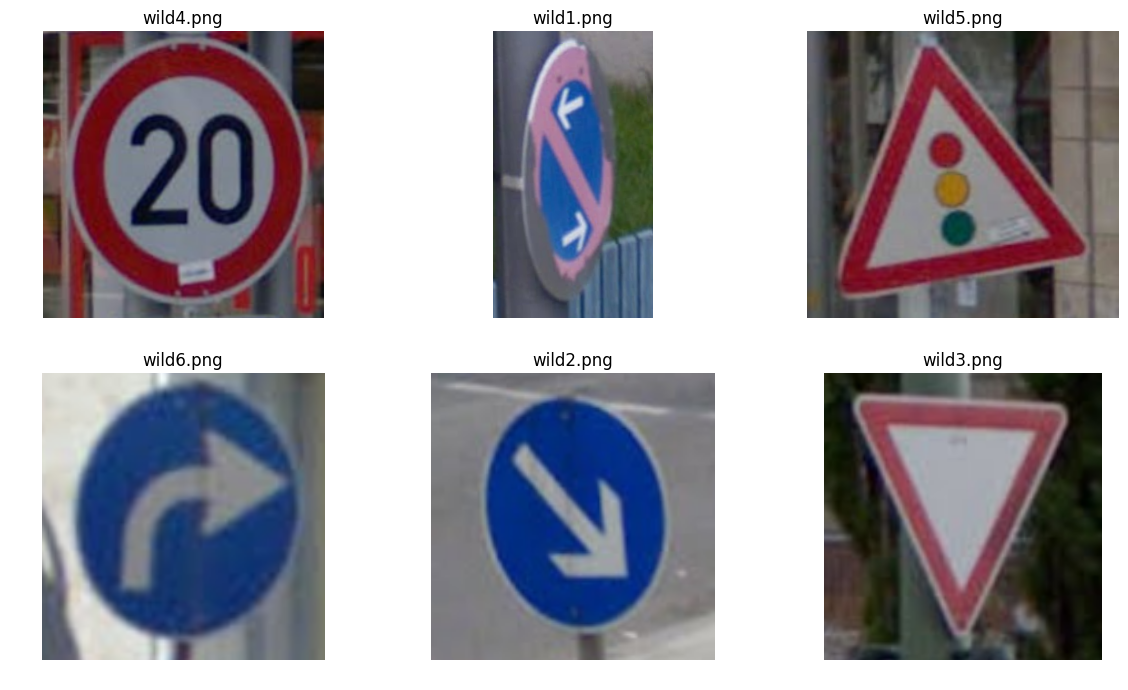

In [31]:
fig = plt.figure(figsize=(12, 7))
i = 1
for filename in d:
    if ".png" not in filename:
        continue
    img = Image.open(directory + filename, 'r')
    fig.add_subplot(2, 3, i)
    i += 1
    plt.title(filename)
    plt.axis("off")
    plt.imshow(img)
plt.tight_layout()
plt.show()

Direct link to respective Street Views follows:
* wild1:  
https://www.google.com/maps/@48.1270027,11.6670881,3a,17y,67.38h,74.06t/data=!3m6!1e1!3m4!1sQzcxxu-IeSZ7MjPvrQ52-g!2e0!7i13312!8i6656
* wild2:  
https://www.google.com/maps/@52.5133944,13.4241218,3a,27.3y,95.36h,78.62t/data=!3m6!1e1!3m4!1sEfCjBjlb1iAdM-Y1n0g4bQ!2e0!7i13312!8i6656
* wild3:  
https://www.google.com/maps/@52.5132373,13.4238683,3a,15y,76.74h,89.2t/data=!3m6!1e1!3m4!1sjf7DAYY6QbH5pHbIvbeR9w!2e0!7i13312!8i6656
* wild4:  
https://www.google.com/maps/@51.0507181,13.7339708,3a,23.8y,142.08h,89.33t/data=!3m6!1e1!3m4!1sd36go-4KZaw4xbdIRe0aNw!2e0!7i13312!8i6656
* wild5:  
https://www.google.com/maps/@51.0506226,13.7346645,3a,15y,129.09h,87.83t/data=!3m6!1e1!3m4!1sCatpqf3Y7J9J-NB2XwDcNQ!2e0!7i13312!8i6656
* wild6:  
https://www.google.com/maps/@50.9264095,6.946066,3a,15y,157.41h,92.85t/data=!3m6!1e1!3m4!1szY2dq0nT5oCGZ4nbPnxUkQ!2e0!7i13312!8i6656

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**  
Note that `wild1` is heavily-skewed (this was the only good shot Street View had of this sign).  This will make classification more difficult than if the photo of the street sign was taken head-on.

Note further that `wild3` and `wild5` are not perfectly level, but are rotated slightly from being level.  This also will make classification more difficult than if these images were level.

Note that `wild1` has corroded significantly (or been painted over?).  This will make classification more difficult than if the sign were clean.  Similarly, note that `wild4` and `wild5` have what appear to be small stickers on them.  While these stickers do not change the meaning of the sign to a human, they could very well affect the performance of the above-trained classifier, for reasons that may not be [entirely apparent](http://www.theverge.com/2016/11/3/13507542/facial-recognition-glasses-trick-impersonate-fool).

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [32]:
def wild_preprocess(img):
    '''
    Given an Image object, returns a numpy array of preprocessed, reshaped inputs.
    
    (1) Resize the Image to 32 x 32
    (2) convert the Image to a Numpy array
    (3) apply preprocess
    '''
    res = img.resize((32, 32))
    arr = np.array(res)
    return preprocess(arr)

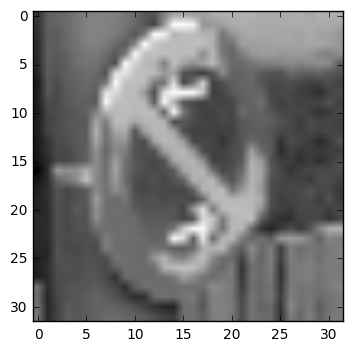

In [33]:
f = Image.open(directory + "wild1.png", 'r')

arr = wild_preprocess(f)
round_arr = np.array(np.round(arr), dtype=np.uint8)
img = Image.fromarray(round_arr)

plt.imshow(img, cmap="Greys_r")

In [34]:
X_wild = np.empty((6, 32, 32, 3),dtype="uint8")

In [35]:
y_wild = np.empty((6,43),dtype="uint8")

In [36]:
for filename in d:
    if ".png" not in filename:
        continue
    img = Image.open(directory + filename, 'r')
    np.append(X_wild, wild_preprocess(img))

In [39]:
X_wild_res = reshapeAndPreprocess(X_wild)

In [41]:
feed_dict_wild = {tf_x: X_wild_res, keep_prob: 1}
top5 = tf.nn.top_k(layOut, 5)
predictions = sess.run(layOut, feed_dict = feed_dict_wild)
top5_pred = sess.run([layOut, top5], feed_dict=feed_dict_wild)

RuntimeError: Attempted to use a closed Session.

In [59]:
with sess.as_default():
    prediction=tf.argmax(tf_y,1)
    preds = prediction.eval(feed_dict={tf_x: X_wild_res, tf_y:y_wild, keep_prob: 1})
    print("predictions:", preds)

predictions: [ 1 41 21 24 38 26]


In [69]:
preds

array([ 1, 41, 21, 24, 38, 26])

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

In [74]:
top5_pred

[array([[ 0.28194541,  0.30584946, -0.13270743, -1.23812521,  0.41746777,
         -1.00194168,  1.11231852, -0.12362679,  0.50194132,  0.7946645 ,
         -1.16772544,  1.23827171,  0.28083068,  1.39955246, -1.30365789,
          0.81620598, -0.17125949,  0.07611918,  0.6719839 ,  0.48654166,
         -2.71469831,  0.64838964,  0.48614416,  0.01200807, -0.56577504,
         -0.37391767, -1.38765764, -0.25652924, -1.38691247, -1.44391954,
          0.95747077,  0.0037254 , -0.58432859, -0.88255852,  0.24769048,
          0.95124441, -1.22931373, -0.87486798,  0.65861601,  0.416852  ,
         -0.68317533,  0.28571376,  0.08198231],
        [ 0.28194541,  0.30584946, -0.13270743, -1.23812521,  0.41746777,
         -1.00194168,  1.11231852, -0.12362679,  0.50194132,  0.7946645 ,
         -1.16772544,  1.23827171,  0.28083068,  1.39955246, -1.30365789,
          0.81620598, -0.17125949,  0.07611918,  0.6719839 ,  0.48654166,
         -2.71469831,  0.64838964,  0.48614416,  0.01200807, -0

In [82]:
import pandas as pd

In [85]:
df=pd.read_csv('signnames.csv', sep=',', index_col=0)
df

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


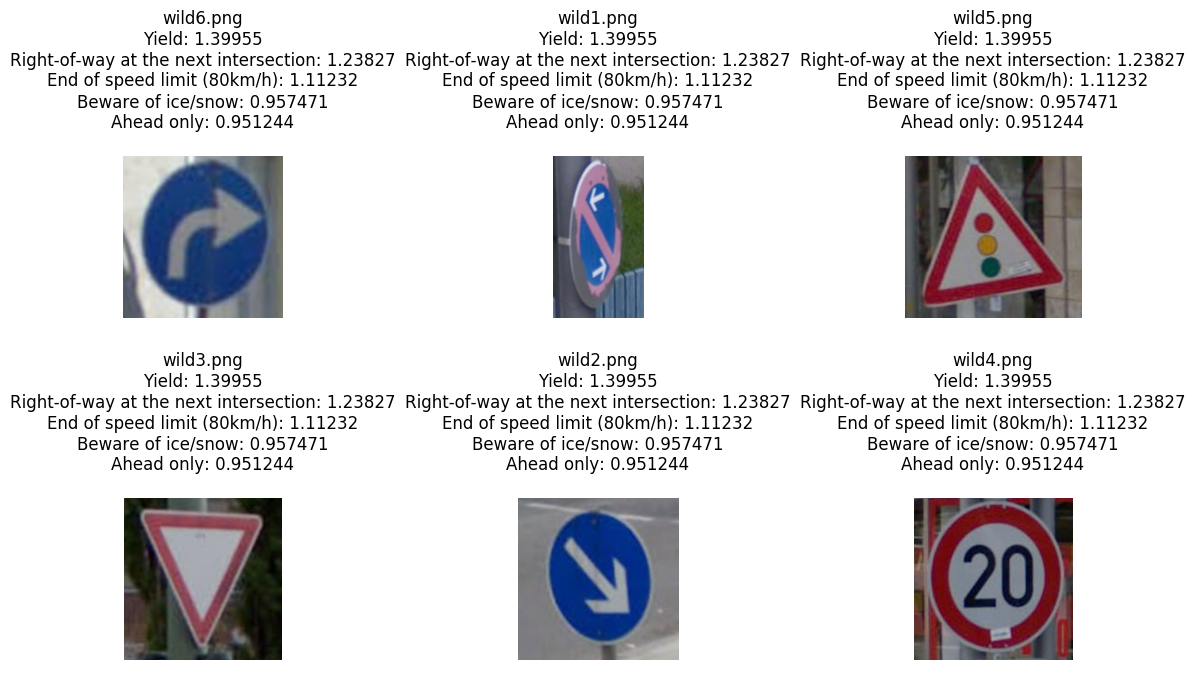

In [100]:
fig = plt.figure(figsize=(12, 7))
i = 1
for filename in d:
    if ".png" not in filename:
        continue
    img = Image.open(directory + filename, 'r')
    fig.add_subplot(2, 3, i)
    titleString = filename + "\n"
    for j, cl in enumerate(top5_pred[1][1][i-1]):
        titleString += df['SignName'][cl] + ": " + str(top5_pred[1][0][i-1][j]) + "\n"
    plt.title(titleString)
    plt.axis("off")
    plt.imshow(img)
    i += 1
plt.tight_layout()
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**  
As can be seen above, the model is not particularly certain of any of its predictions, and is not generally correct either.

Several factors likely contribute to this:  
1. The model has too simplistic of an architecture.  It's simply not deep enough to allow for the performance seen in other Deep Neural Net models.  Traditionally, the reason why depth increases performance [has been conceptualized](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/05f91f07-6de6-4b6b-b989-6112802e09a4) as each successive layer allowing for more-complex features to emerge.  That is, while the first layer of a Neural Network may be able to tell whether there are horizontal, vertical, or diagonal lines, the second layer may be able to notice the presence of multiple concentric lines or circles, and successively-higher layers may be able to discern different shapes of tesselations, and more.  It's usually here that our conceptual understanding of Neural Nets, along with the vocabulary we use to describe them, breaks down.  But what seems to be constant is that Neural Nets can indeed be too shallow for complex tasks, and that seems to be the case here.  
2. The model was not trained for long enough.  That's simply a question of time.  This Jupyter Notebook was created on a laptop without a Graphics Processing Unit.  As such, it was not able to benefit from the massively-parallel architecture that such a coprocessor is able to offer (and that libraries such as Google's `TensorFlow` are able to take huge advantage of).  There is a point after which the model begins to overfit the training data at the expense of the testing data, but I'm willing to go out on a limb and to suggest that I hadn't reached that point yet.  
3. I [don't understand](https://carnd-udacity.atlassian.net/wiki/questions/18449618/how-to-ask-your-tensor-for-a-classification) how to ask `TensorFlow` for predictions.  It seems like I just got the exact same prediction for all of the wild images, which shouldn't be right, although I admit that it could be if my model was so simplistic as to just guess the same class for every image.  I don't think that behavior is occurring, though, since `preds` from above is an alternate way of asking for predictions, which seemed at least to yield predictions which (1) differed from image to image, and (2) differed from the predictions which the first method yielded.  

I am aware of other models that have been built for this course achieving high-90% test accuracy, so I know that such a model is possible to design and train, however I myself am unclear about how to design and train such a model.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [ ]:
sess.close()